<a href="https://colab.research.google.com/github/Dwash71/Sales-Forecasting-Pandas/blob/main/Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!pip install xgboost

In [59]:
!pip install scikit-learn

In [60]:
!pip install tensorflow
!pip install keras

In [61]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [62]:
store_sales = pd.read_csv('train.csv')
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


chek for null values in dataset

In [63]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


dropping store and items columns

In [64]:
store_sales = store_sales.drop(['store', 'item'], axis=1)

In [65]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


converting date from object datetype to dateTime datatype

In [66]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [67]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


converting date to a Month period, and then sum the number of items in each month

In [68]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()

convert the resulting date column to timestamp datatype

In [69]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [70]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


call the difference on the sales columns to make the sales data stationery

In [71]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthy_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
0,2013-01-01,454904,NaN
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0


Visualization

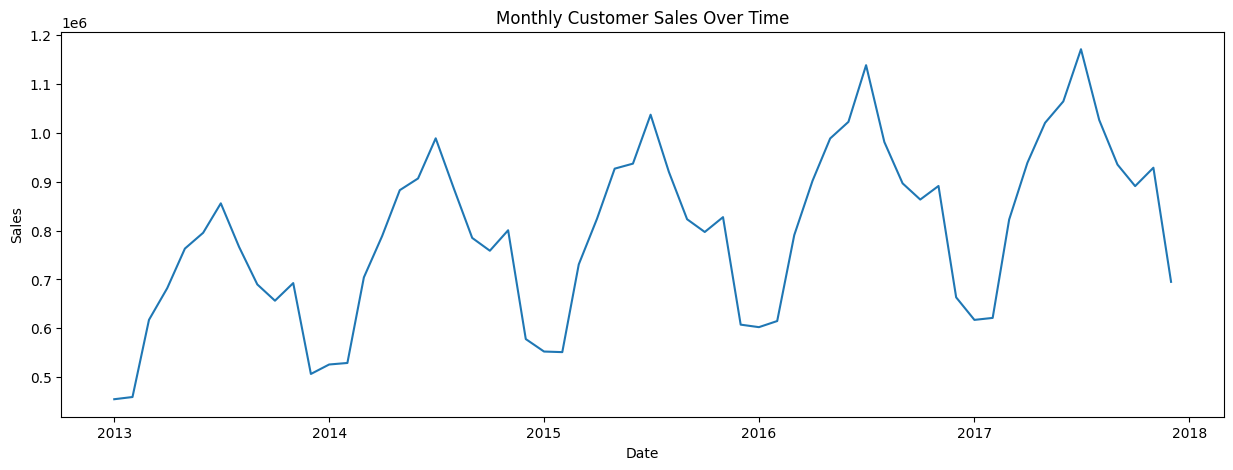

In [72]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales Over Time')
plt.show()

Dropping off sales and date

In [73]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

preparing the supervised data

In [74]:
for i in range(1, 13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Split the data into Train and Test

In [75]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape", train_data.shape)
print("Test Data Shape", test_data.shape)

Train Data Shape (35, 13)
Test Data Shape (12, 13)


use scaler for Min Max

In [76]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

Declare x_train and y_train

In [77]:
x_train, y_train = train_data[:, 1:], train_data[:,0:1]
x_test, y_test = test_data[:, 1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train shape", x_train.shape)
print("Y_train shape", y_train.shape)
print("X_test shape", x_test.shape)
print("Y_test shape", y_test.shape)

X_train shape (35, 12)
Y_train shape (35,)
X_test shape (12, 12)
Y_test shape (12,)


Make prediction data frame to merge the predicted sales prices of all trained algorithms

In [78]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
prediction_df = pd.DataFrame(sales_dates)

acutal and forecasted sales

In [79]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


Create the linear regression model, and the predicted output

In [80]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pred = lr_model.predict(x_test)

call function for inverse_transform

In [81]:
lr_pred = lr_pred.reshape(-1, 1)
#This is a set matrix - that contains the input features of test data and predicted output
lr_pred_test_set = np.concatenate([lr_pred, x_test], axis=1)
lr_pred_test_set = scaler.inverse_transform(lr_pred_test_set)

calculate predicted sale values  and merge

In [82]:
result_list = []
for i in range(0, len(lr_pred_test_set)):
    result_list.append(lr_pred_test_set[i][0] + act_sales[i])
lr_pre_series = pd.Series(result_list, name='Linear Prediction')
prediction_df = prediction_df.merge(lr_pre_series, left_index = True, right_index = True)

means square error, absolute error and score error

In [83]:
#print(prediction_df)
lr_mse = np.sqrt(mean_squared_error(prediction_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(prediction_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(prediction_df['Linear Prediction'], monthly_sales['sales'][-12:])

print("Linear Regression MSE: ", + lr_mse)
print("Linear Regression MAE: ", + lr_mae)
print("Linear Regression R2: ", + lr_r2)


Linear Regression MSE:  16221.272385416869
Linear Regression MAE:  12433.184266490736
Linear Regression R2:  0.9906152516380969


Visualization of the prediction against the actual sales

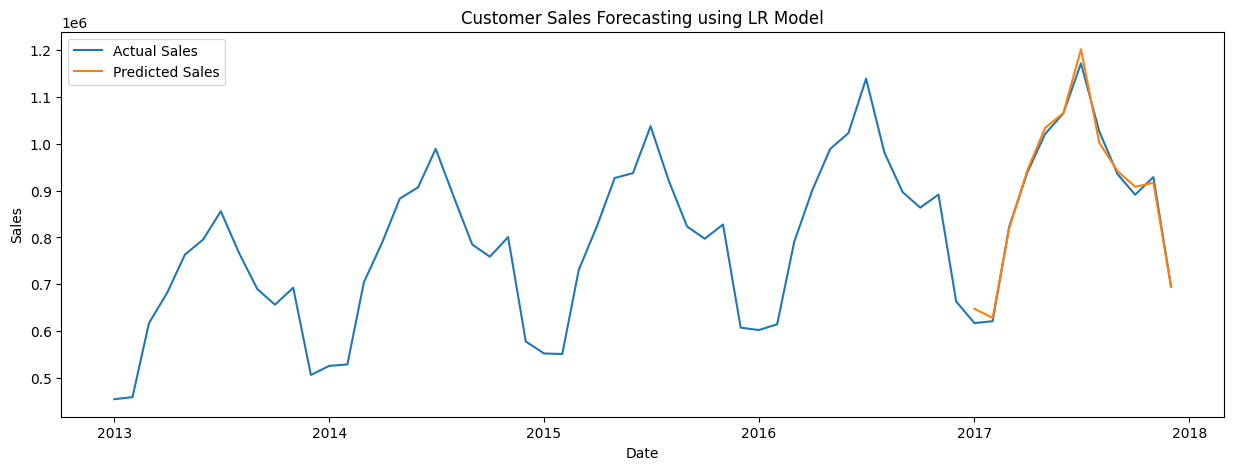

In [86]:
plt.figure(figsize=(15, 5))
#Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'], label='Actual Sales')
#Predicted Sales
plt.plot(prediction_df['date'], prediction_df['Linear Prediction'], label='Predicted Sales')
plt.title('Customer Sales Forecasting using LR Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()